In [78]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import pandas
import sunode.wrappers.as_theano as sun


## Generate Data
df = pandas.read_csv('hudson-bay-linx-hare.csv',header=1)

year = df['Year']
lynx = df['Lynx']
hare = df['Hare']

times = np.array(year,dtype=float)
yobs = np.array([hare,lynx]).T 
yobs_norm = yobs / yobs.std(axis=0)


## Do Bayesian Sindy
def predator_prey_sunode_library(t, y, p):
    du_dt = p.pn[0] * y.u + p.pn[2] * y.v + p.pn[4] * y.u * y.v + p.pn[6] * y.u**2 + p.pn[8]* y.v**2 + p.pn[10] - 1e-5 * y.u**3
    dv_dt = p.pn[1] * y.u + p.pn[3] * y.v + p.pn[5] * y.u * y.v + p.pn[7] * y.u**2 + p.pn[9]*y.v**2 + p.pn[11] - 1e-5 * y.v**3
    return {'u': du_dt, 'v' : dv_dt}


d = 12

model_ss = pm.Model()

with model_ss:

    sigma = pm.Lognormal('sigma', mu=-1, sigma=0.1, shape=2)
    pn = pm.Laplace('pn', mu=0, b=1, shape=d)
    xi = pm.Bernoulli('xi', 0.8, shape=d)
    pnss = pm.Deterministic('pnss', pn * xi)
    y0 = pm.Lognormal('y0', mu=pm.math.log(1), sigma=1, shape=2)

    y_hat = sun.solve_ivp(
        y0={
            'u': (y0[0], ()),
            'v': (y0[1], ()),
            },
            params={
                'pn' : (pnss,d),
                'tmp': np.zeros(1),  # Theano wants at least one fixed parameter
            },
            rhs=predator_prey_sunode_library,
    make_solver='BDF',
            tvals=times,
            t0=times[0],
        )[0]

    uobs = pm.Lognormal('uobs', mu=pm.math.log(y_hat['u'][:]), sigma=sigma[0], observed=yobs_norm[:,0])
    vobs = pm.Lognormal('vobs', mu=pm.math.log(y_hat['v'][:]), sigma=sigma[1], observed=yobs_norm[:,1])

    start = pm.find_MAP()

    # Initialize parameters with least squares and all other values with MAP
    inp = yobs_norm
    u = inp[:,0]
    v = inp[:,1]

    θ = np.array([u,v,u*v,u**2,v**2,np.ones(u.shape)]).T

    import pysindy as ps
    from pysindy.differentiation import SmoothedFiniteDifference
    sfd = SmoothedFiniteDifference(smoother_kws={'window_length': 5})
    dx = sfd(inp)

    guess = np.linalg.lstsq(θ,dx)[0]
    
    print('Initialization')
    print(guess)

    start['pn'] = guess.flatten()
    start['pnss'] = start['pn']
    start['xi'] = np.ones(start['pn'].shape).astype(int)
    start['y0'] = yobs_norm[0,:]
    start['y0_log__'] = np.log(start['y0'])

    #trace = pm.sample(4000, tune=1000, cores=2, start=start,random_seed=0,step_kwargs={'nuts':{'target_accept':0.95}})

    real_ss_12param = pm.backends.load_trace('real_ss_12param' + '.trace',model_ss)

# If you want to plot it make sure you can display graphics when you ssh
#plt.figure()
#plt.traceplot(trace)
#plt.savefig('synthetic_reg_minus_5_full_sindy_10.png')

#import sys
#print(sys.argv[0])
#print('done')
'''
plt.figure(figsize=(4,10))
ax = plt.axes()
ax.plot([0, 0], [-0.05, 0.5], 'k--')
pm.forestplot((real_ss_12param['pnss']).T, credible_interval=0.95, kind='ridgeplot', ridgeplot_overlap=0.1, ax=ax)
#ax.set_title('')
ax.set_xlabel('Coefficient value')
ax.set_ylabel('Coefficient')
ax.set_xlim(-2, 1.5)
ax.set_ylim(-0.05, 0.5)
ax.set_yticks(np.array([0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55])*0.85 - 0.01)
ax.set_yticklabels([ r'$\dot{u} \ \colon \ u$', r'$\dot{v} \ \colon \ u$',
                    r'$\dot{u} \ \colon \ v$', r'$\dot{v} \ \colon \ v$',
                    r'$\dot{u} \ \colon \ u v$', r'$\dot{v} \ \colon \ u v$',
                    r'$\dot{u} \ \colon \ u^2$', r'$\dot{v} \ \colon \ u^2$',
                    r'$\dot{u} \ \colon \ v^2$', r'$\dot{v} \ \colon \ v^2$',
                    r'$\dot{v} \ \colon \ 1$', r'$\dot{u} \ \colon \ 1$'], fontsize=16)'''
    





logp = -91, ||grad|| = 505.17: 100%|██████████| 8/8 [00:00<00:00, 243.05it/s]

Initialization
[[ 0.67745872 -0.08466578]
 [-0.09671527 -1.14033485]
 [-0.16558271  0.15817824]
 [-0.09951633  0.11087658]
 [-0.04709275  0.23517823]
 [-0.17829224  0.20845188]]



/home/hirshs/anaconda3/envs/mars-sunode/lib/python3.7/site-packages/ipykernel_launcher.py:72: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


"\nplt.figure(figsize=(4,10))\nax = plt.axes()\nax.plot([0, 0], [-0.05, 0.5], 'k--')\npm.forestplot((real_ss_12param['pnss']).T, credible_interval=0.95, kind='ridgeplot', ridgeplot_overlap=0.1, ax=ax)\n#ax.set_title('')\nax.set_xlabel('Coefficient value')\nax.set_ylabel('Coefficient')\nax.set_xlim(-2, 1.5)\nax.set_ylim(-0.05, 0.5)\nax.set_yticks(np.array([0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55])*0.85 - 0.01)\nax.set_yticklabels([ r'$\\dot{u} \\ \\colon \\ u$', r'$\\dot{v} \\ \\colon \\ u$',\n                    r'$\\dot{u} \\ \\colon \\ v$', r'$\\dot{v} \\ \\colon \\ v$',\n                    r'$\\dot{u} \\ \\colon \\ u v$', r'$\\dot{v} \\ \\colon \\ u v$',\n                    r'$\\dot{u} \\ \\colon \\ u^2$', r'$\\dot{v} \\ \\colon \\ u^2$',\n                    r'$\\dot{u} \\ \\colon \\ v^2$', r'$\\dot{v} \\ \\colon \\ v^2$',\n                    r'$\\dot{v} \\ \\colon \\ 1$', r'$\\dot{u} \\ \\colon \\ 1$'], fontsize=16)"

In [36]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import pandas
import sunode.wrappers.as_theano as sun


## Generate Data
df = pandas.read_csv('hudson-bay-linx-hare.csv',header=1)

year = df['Year']
lynx = df['Lynx']
hare = df['Hare']

times = np.array(year,dtype=float)
yobs = np.array([hare,lynx]).T 
yobs_norm = yobs / yobs.std(axis=0)

slab_df = 4
slab_scale = 2

## Do Bayesian Sindy
def predator_prey_sunode_library(t, y, p):
    du_dt = p.pn[0] * y.u + p.pn[2] * y.v + p.pn[4] * y.u * y.v + p.pn[6] * y.u**2 + p.pn[8]* y.v**2 + p.pn[10] - 1e-5 * y.u**3
    dv_dt = p.pn[1] * y.u + p.pn[3] * y.v + p.pn[5] * y.u * y.v + p.pn[7] * y.u**2 + p.pn[9]*y.v**2 + p.pn[11] - 1e-5 * y.v**3
    return {'u': du_dt, 'v' : dv_dt}

model_rh = pm.Model()

d = 12

with model_rh:

    sigma = pm.Lognormal('sigma', mu=-1, sigma=0.1, shape=2)
    
    l = pm.HalfStudentT('l', nu=1, sigma=1, shape=d)
    tau = pm.HalfStudentT('tau', nu=1, sigma=0.01)
    c2 = pm.InverseGamma('c2', alpha=0.5*slab_df, beta=0.5*slab_df*slab_scale**2)
    
    lt = (pm.math.sqrt(c2)*l) / pm.math.sqrt(c2 + pm.math.sqr(tau) * pm.math.sqr(l))
    
    z  = pm.Normal('z', mu=0, sigma=1, shape=d)
    pn = pm.Deterministic('pn', z*tau*lt)
    #pn = pm.Normal('pn', mu=0, sigma=tau*l, shape=10)
    
    y0 = pm.Lognormal('y0', mu=pm.math.log(1), sigma=1, shape=2)

    y_hat = sun.solve_ivp(
        y0={
            'u': (y0[0], ()),
            'v': (y0[1], ()),
            },
            params={
                'pn' : (pn,d),
                'tmp': np.zeros(1),  # Theano wants at least one fixed parameter
            },
            rhs=predator_prey_sunode_library,
    make_solver='BDF',
            tvals=times,
            t0=times[0],
        )[0]

    uobs = pm.Lognormal('uobs', mu=pm.math.log(y_hat['u'][:]), sigma=sigma[0], observed=yobs_norm[:,0])
    vobs = pm.Lognormal('vobs', mu=pm.math.log(y_hat['v'][:]), sigma=sigma[1], observed=yobs_norm[:,1])


    #trace = pm.sample(1000, tune=500, cores=2, random_seed=0, target_accept=0.99)

    real_rh_12param = pm.backends.load_trace('real_rh_12param' + '.trace',model_rh)




100%|██████████| 8000/8000 [00:30<00:00, 261.46it/s]


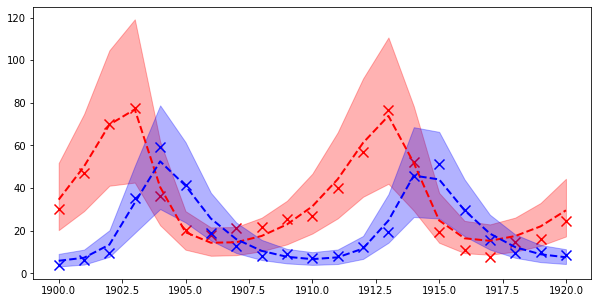

In [16]:
# plot mean and intervals
with model_ss:
    ppc_ss = pm.sample_posterior_predictive(real_ss_12param, var_names=['uobs','vobs'], random_seed=2)

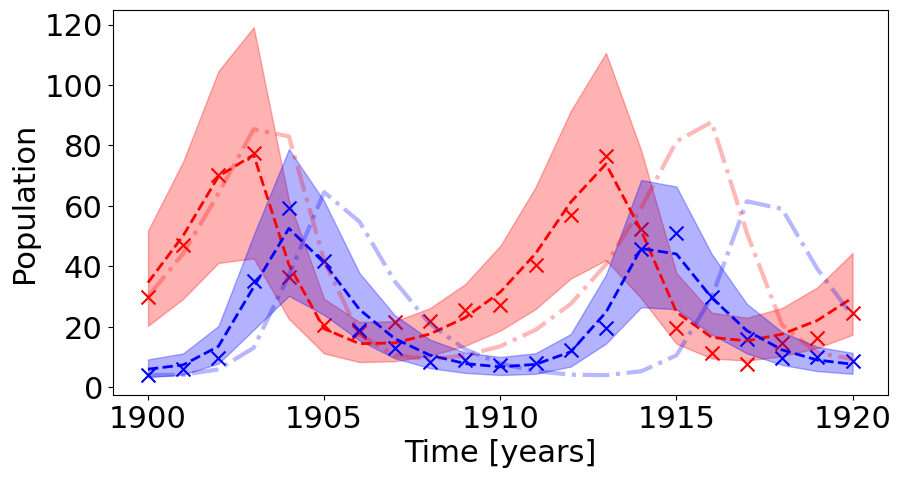

In [194]:
plt.figure(figsize=(10,5))
name = ['uobs','vobs']
colors = ['r','b']
for i in range(2):
    series = ppc_ss[name[i]].T * yobs.std(axis=0)[i]
    above = np.percentile(series,90,axis=1)
    below = np.percentile(series,10,axis=1)
    mu = series.mean(axis=1)
    plt.plot(times, mu, '--', color=colors[i], lw=2, label="mean");
    plt.plot(times,sim[:, 0]*np.std(yobs,axis=0)[0], "-.", color='red',alpha=0.15,label="SINDy model", linewidth=3)
    plt.plot(times,sim[:, 1]*np.std(yobs,axis=0)[1], "-.", color='blue',alpha=0.15,label="SINDy model", linewidth=3)
    plt.fill_between(times, below, above, color=colors[i], alpha=0.3)
    plt.scatter(times, yobs[:,i], color=colors[i],marker='x',s=100, alpha=1.0, label="observed data");
    plt.xticks([1900,1905,1910,1915,1920],fontsize=22)
    plt.yticks(fontsize=22)
    plt.xlabel('Time [years]',fontsize=22)
    plt.ylabel('Population',fontsize=22)

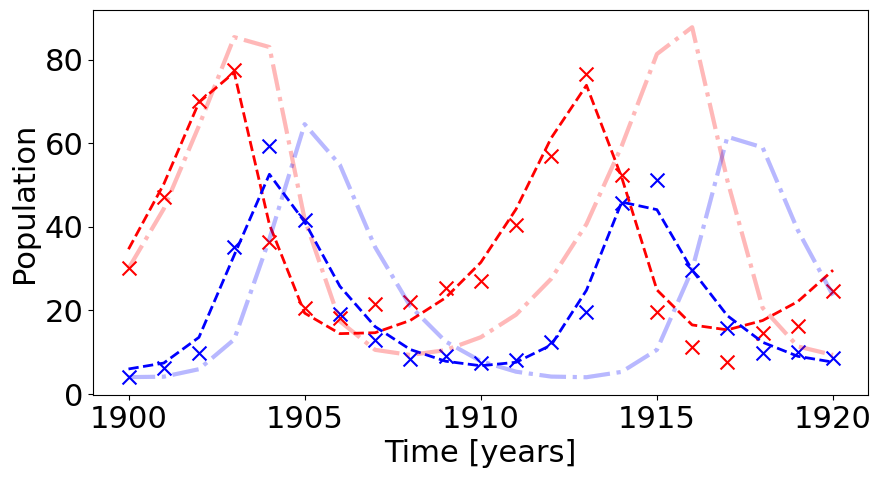

In [197]:
plt.figure(figsize=(10,5))
name = ['uobs','vobs']
colors = ['r','b']
for i in range(2):
    series = ppc_ss[name[i]].T * yobs.std(axis=0)[i]
    above = np.percentile(series,90,axis=1)
    below = np.percentile(series,10,axis=1)
    mu = series.mean(axis=1)
    plt.plot(times, mu, '--', color=colors[i], lw=2, label="mean");
    plt.plot(times,sim[:, 0]*np.std(yobs,axis=0)[0], "-.", color='red',alpha=0.15,label="SINDy model", linewidth=3)
    plt.plot(times,sim[:, 1]*np.std(yobs,axis=0)[1], "-.", color='blue',alpha=0.15,label="SINDy model", linewidth=3)
    plt.scatter(times, yobs[:,i], color=colors[i],marker='x',s=100, alpha=1.0, label="observed data");
    plt.xticks([1900,1905,1910,1915,1920],fontsize=22)
    plt.yticks(fontsize=22)
    plt.xlabel('Time [years]',fontsize=22)
    plt.ylabel('Population',fontsize=22)

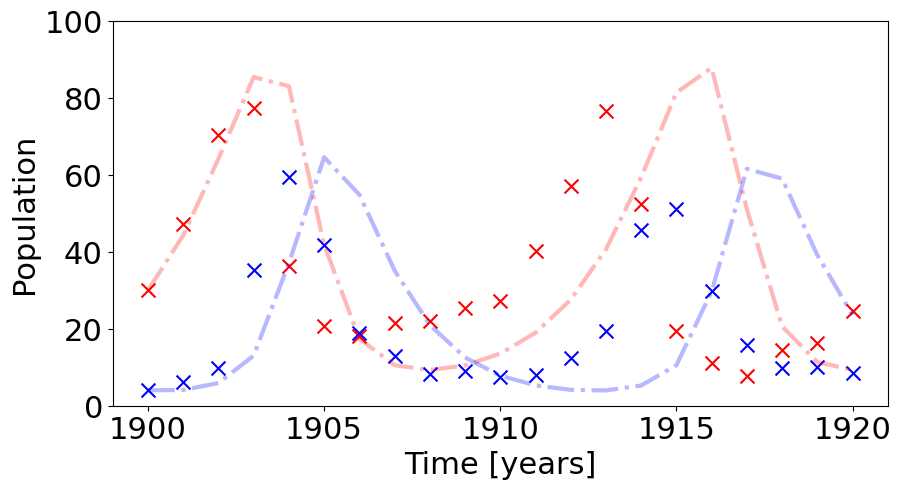

In [199]:
plt.figure(figsize=(10,5))
name = ['uobs','vobs']
colors = ['r','b']
for i in range(2):
    series = ppc_ss[name[i]].T * yobs.std(axis=0)[i]
    above = np.percentile(series,90,axis=1)
    below = np.percentile(series,10,axis=1)
    mu = series.mean(axis=1)
    plt.scatter(times, yobs[:,i], color=colors[i],marker='x',s=100, alpha=1.0, label="observed data");
    plt.plot(times,sim[:, 0]*np.std(yobs,axis=0)[0], "-.", color='red',alpha=0.15,label="SINDy model", linewidth=3)
    plt.plot(times,sim[:, 1]*np.std(yobs,axis=0)[1], "-.", color='blue',alpha=0.15,label="SINDy model", linewidth=3)
    plt.xticks([1900,1905,1910,1915,1920],fontsize=22)
    plt.ylim([0,100])
    plt.yticks(fontsize=22)
    plt.xlabel('Time [years]',fontsize=22)
    plt.ylabel('Population',fontsize=22)

In [181]:
np.std(yobs,axis=0)[0]

array([20.89790646, 16.25459154])

100%|██████████| 2000/2000 [00:08<00:00, 227.14it/s]


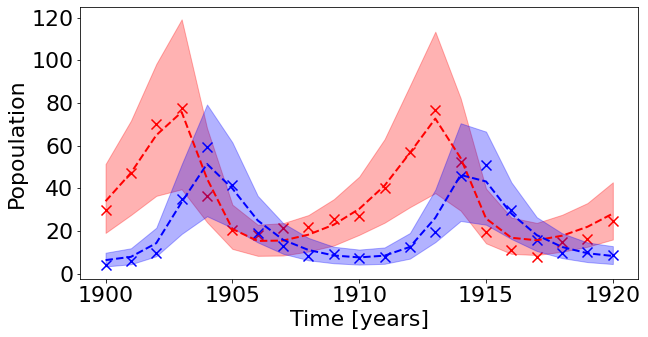

In [45]:
# plot mean and intervals
with model_rh:
    ppc_rh = pm.sample_posterior_predictive(real_rh_12param, var_names=['uobs','vobs'], random_seed=2)



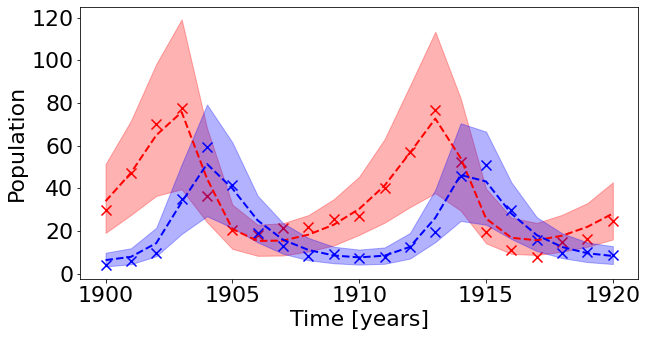

In [46]:
plt.figure(figsize=(10,5))
name = ['uobs','vobs']
colors = ['r','b']
for i in range(2):
    series = ppc_rh[name[i]].T * yobs.std(axis=0)[i]
    above = np.percentile(series,90,axis=1)
    below = np.percentile(series,10,axis=1)
    mu = series.mean(axis=1)
    plt.plot(times, mu, '--', color=colors[i], lw=2, label="mean");
    plt.fill_between(times, below, above, color=colors[i], alpha=0.3)
    plt.scatter(times, yobs[:,i], color=colors[i],marker='x',s=100, alpha=1.0, label="observed data");
    plt.xticks([1900,1905,1910,1915,1920],fontsize=22)
    plt.yticks(fontsize=22)
    plt.xlabel('Time [years]',fontsize=22)
    plt.ylabel('Population',fontsize=22)
    

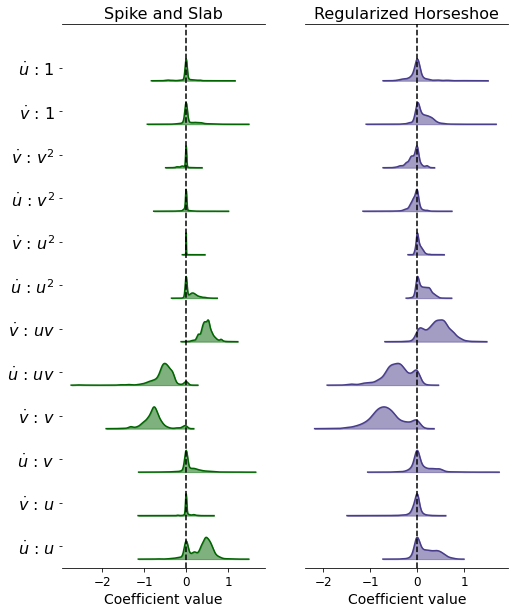

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# create some data
n = 1000
exps = (real_ss_12param['pnss'].T, real_rh_12param['pn'].T)


colors = ['darkgreen','darkslateblue']

fig, ax = plt.subplots(1,2)
for sbplt, var in enumerate(exps):
    for i, v in enumerate(var):
        sns.kdeplot(data=v,color=colors[sbplt],ax=ax[sbplt])


for r in range(2):    
# find the line and rescale y-values
    children = ax[r].get_children()
    c = 0
    for child in children:
        if isinstance(child, matplotlib.lines.Line2D):
            x, y = child.get_data()
            y = y/y.max() * 0.5 + c + 0.2
            child.set_data(x,y)
            ax[r].fill_between(x,c + 0.2, y, alpha=0.5,color=colors[r])
            c+= 1
        
for i in range(2):
    ax[i].set_ylim([0,12.5])
    ax[i].set_xlabel('Coefficient value', fontsize=14)
    ax[i].set_ylabel('')
    ax[i].set_title(['Spike and Slab','Regularized Horseshoe'][i], fontsize=16)
    ax[i].plot([0, 0], [0, 20], 'k--')
    ax[i].set_yticks([])  
    ax[i].tick_params(axis='x', which='major', labelsize=12)
    ax[i].spines['left'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    #ax[i].axis('off')
    
ax[0].set_yticks(np.arange(12) + 0.5)
#ax[0].set_yticks(np.array([0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55]) * 0.85 - 0.01)
ax[0].set_yticklabels([ r'$\dot{u} \ \colon \ u$', r'$\dot{v} \ \colon \ u$',
                    r'$\dot{u} \ \colon \ v$', r'$\dot{v} \ \colon \ v$',
                    r'$\dot{u} \ \colon \ u v$', r'$\dot{v} \ \colon \ u v$',
                    r'$\dot{u} \ \colon \ u^2$', r'$\dot{v} \ \colon \ u^2$',
                    r'$\dot{u} \ \colon \ v^2$', r'$\dot{v} \ \colon \ v^2$',
                    r'$\dot{v} \ \colon \ 1$', r'$\dot{u} \ \colon \ 1$'], fontsize=16)
    
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(8, 10)

In [25]:
real_ss_12param['xi'].mean(axis=0).reshape(2,6,order='F')

array([[0.845625, 0.5375  , 0.957875, 0.581   , 0.31375 , 0.468875],
       [0.341125, 0.993875, 0.99975 , 0.081875, 0.3545  , 0.35275 ]])

In [42]:
# create some data
n = 1000
exps = (real_ss_12param['pnss'].T, real_rh_12param['pn'].T)


colors = ['darkgreen','darkslateblue']

fig, ax = plt.subplots(1,2)
for sbplt, var in enumerate(exps):
    for i, v in enumerate(var):
        sns.kdeplot(data=v,color=colors[sbplt],ax=ax[sbplt])
        if i==11 and sbplt==0:
            sns.kdeplot(data=var[-1,:],color=colors[sbplt],ax=ax[sbplt])

                       
for r in range(2): 
    print(['SS','RH'][r])
# find the line and rescale y-values
    children = ax[r].get_children()
    c = 0
    for child in children:
        if isinstance(child, matplotlib.lines.Line2D):
            x, y = child.get_data()
            print(x[np.argmax(y)])
            y = y/y.max() * 0.5 + c + 0.2
            child.set_data(x,y)
            ax[r].fill_between(x,c + 0.2, y, alpha=0.5,color=colors[r])
            c+= 1
            
plt.close()

SS
0.4731022355773751
0.0011736492818708033
0.003138211156737958
-0.7625083619633997
-0.5098475498734265
0.5248906051479061
0.0025694743136761566
0.0012288050218589586
-0.0022269753519138513
-0.00026484307808316565
-0.000650080826361199
0.0038982634552746642
0.0038982634552746642
RH
-0.0026876287530775977
-0.006796408127881071
-0.0002703833511845666
-0.7040288229198701
-0.4182993178208272
0.5227575987474956
0.007702147655146457
0.00445838132354115
-0.00485958011602361
-0.006251513542719467
0.01131087666277275
0.0027636724912109


In [38]:
real_rh_12param

<MultiTrace: 2 chains, 1000 iterations, 12 variables>

In [41]:
real_rh_12param['pn'].T

array([[ 0.4867031 ,  0.64353583,  0.60983861, ..., -0.00884077,
        -0.01019126, -0.03009823],
       [ 0.02274714,  0.05700884,  0.08564029, ...,  0.05649858,
        -0.04680188, -0.09200325],
       [ 0.41146655,  0.10454673,  0.39324859, ...,  0.53957742,
         0.37792328,  0.51811623],
       ...,
       [-0.02891835, -0.03943344, -0.02929204, ..., -0.04252231,
        -0.03070079, -0.04386898],
       [-0.11970641, -0.13686005, -0.17200449, ...,  0.07562335,
         0.04194646,  0.06158707],
       [-0.0299951 , -0.07138974, -0.07445608, ..., -0.01833741,
        -0.03323432, -0.01898936]])

In [43]:
real_ss_12param['xi'].mean(axis=0)

array([0.845625, 0.341125, 0.5375  , 0.993875, 0.957875, 0.99975 ,
       0.581   , 0.081875, 0.31375 , 0.3545  , 0.468875, 0.35275 ])

-0.0026876287530775977
-0.006796408127881071
-0.0002703833511845666
-0.7040288229198701
-0.4182993178208272
0.5227575987474956
0.007702147655146457
0.00445838132354115
-0.00485958011602361
-0.006251513542719467
0.01131087666277275
0.0027636724912109
-0.0026876287530775977
-0.006796408127881071
-0.0002703833511845666
-0.7040288229198701
-0.4182993178208272
0.5227575987474956
0.007702147655146457
0.00445838132354115
-0.00485958011602361
-0.006251513542719467
0.01131087666277275
0.0027636724912109


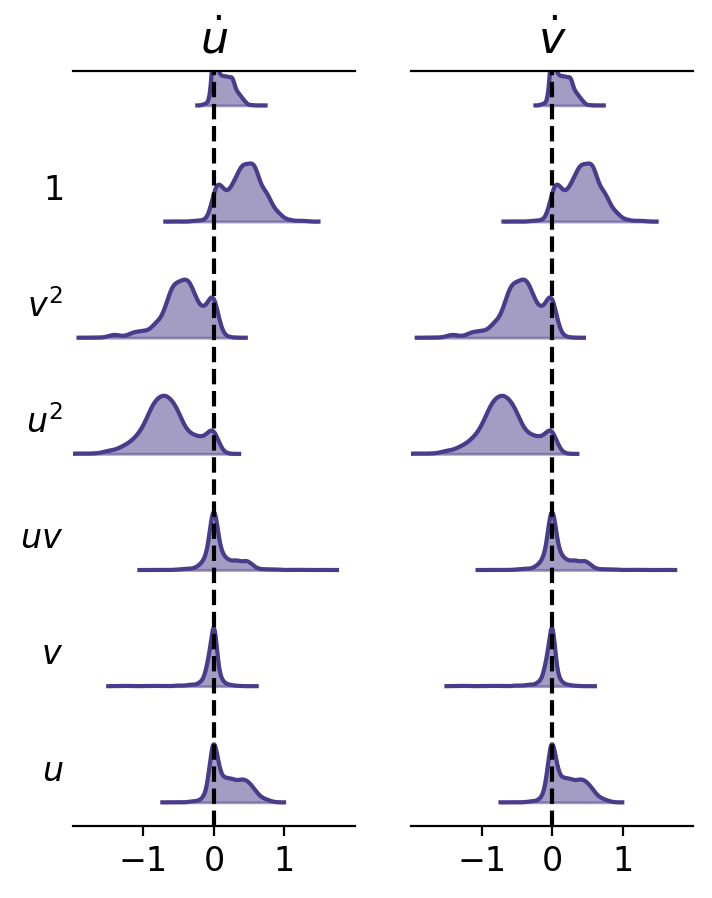

In [74]:
# import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# create some data
n = 1000
#exps = (real_rh_12param['pn'].T[::2,:], real_rh_12param['pn'].T[1::2,:])
exps = (real_rh_12param['pn'].T, real_rh_12param['pn'].T)

colors = ['darkslateblue','darkslateblue']

fig, ax = plt.subplots(1,2,dpi=200)
for sbplt, var in enumerate(exps):
    for i, v in enumerate(var):
        sns.kdeplot(data=v,color=colors[sbplt],ax=ax[sbplt])
        #if i==5 and sbplt==1:
        #    sns.kdeplot(data=var[-1,:],color=colors[sbplt],ax=ax[sbplt])

for r in range(2):    
# find the line and rescale y-values
    children = ax[r].get_children()
    c = 0
    for child in children:
        if isinstance(child, matplotlib.lines.Line2D):
            x, y = child.get_data()
            print(x[np.argmax(y)])
            y = y/y.max() * 0.5 + c + 0.2
            child.set_data(x,y)
            ax[r].fill_between(x,c + 0.2, y, alpha=0.5,color=colors[r])
            c+= 1
        
for i in range(2):
    ax[i].set_ylim([0,6.5])
    #ax[i].set_xlabel('Coefficient value', fontsize=14)
    ax[i].set_ylabel('')
    ax[i].set_title([r'$\dot{u}$',r'$\dot{v}$'][i % 2], fontsize=16)
    ax[i].plot([0, 0], [0, 20], 'k--')
    ax[i].set_yticks([])  
    ax[i].tick_params(axis='x', which='major', labelsize=12)
    ax[i].spines['left'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].set_xticks([-1,0,1])
    ax[i].set_xlim([-2,2])
    #ax[i].axis('off')
    
ax[0].set_yticks(np.arange(6) + 0.5)
#ax[0].set_yticks(np.array([0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55]) * 0.85 - 0.01)
#ax[0].set_yticklabels([ r'$\dot{u} \ \colon \ u$', r'$\dot{v} \ \colon \ u$',
#                    r'$\dot{u} \ \colon \ v$', r'$\dot{v} \ \colon \ v$',
#                    r'$\dot{u} \ \colon \ u v$', r'$\dot{v} \ \colon \ u v$',
#                    r'$\dot{u} \ \colon \ u^2$', r'$\dot{v} \ \colon \ u^2$',
#                    r'$\dot{u} \ \colon \ v^2$', r'$\dot{v} \ \colon \ v^2$',
#                    r'$\dot{v} \ \colon \ 1$', r'$\dot{u} \ \colon \ 1$'][:6], fontsize=16)

ax[0].set_yticklabels([ r'$u$', 
                    r'$v$', 
                    r'$ u v$', 
                    r'$u^2$', 
                    r'$v^2$', 
                    r'$1$'], fontsize=12)
ax[0].yaxis.set_tick_params(length=0)

    
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(4, 5)
plt.savefig('fig5b.pdf')

-0.000650080826361199
0.4731022355773751
0.003138211156737958
-0.5098475498734265
0.0025694743136761566
-0.0022269753519138513
0.0038982634552746642
0.0011736492818708033
-0.7625083619633997
0.5248906051479061
0.0012288050218589586
-0.00026484307808316565


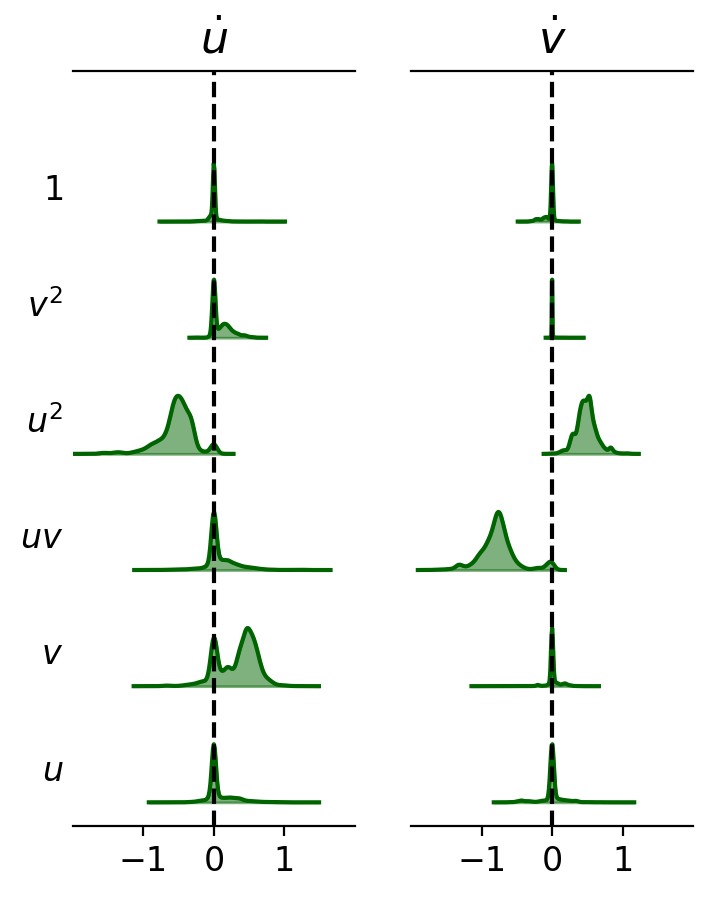

In [61]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# create some data
n = 1000
exps = (real_ss_12param['pnss'].T[::2,:][[5,0,1,2,3,4],:], real_ss_12param['pnss'].T[1::2,:][[5,0,1,2,3,4],:])


colors = ['darkgreen','darkgreen']

fig, ax = plt.subplots(1,2,dpi=200)
for sbplt, var in enumerate(exps):
    for i, v in enumerate(var):
        sns.kdeplot(data=v,color=colors[sbplt],ax=ax[sbplt])
        #if i==5 and sbplt==1:
        #    sns.kdeplot(data=var[-1,:],color=colors[sbplt],ax=ax[sbplt])

for r in range(2):    
# find the line and rescale y-values
    children = ax[r].get_children()
    c = 0
    for child in children:
        if isinstance(child, matplotlib.lines.Line2D):
            x, y = child.get_data()
            print(x[np.argmax(y)])
            y = y/y.max() * 0.5 + c + 0.2
            child.set_data(x,y)
            ax[r].fill_between(x,c + 0.2, y, alpha=0.5,color=colors[r])
            c+= 1
        
for i in range(2):
    ax[i].set_ylim([0,6.5])
    #ax[i].set_xlabel('Coefficient value', fontsize=14)
    ax[i].set_ylabel('')
    ax[i].set_title([r'$\dot{u}$',r'$\dot{v}$'][i % 2], fontsize=16)
    ax[i].plot([0, 0], [0, 20], 'k--')
    ax[i].set_yticks([])  
    ax[i].tick_params(axis='x', which='major', labelsize=12)
    ax[i].spines['left'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].set_xticks([-1,0,1])
    ax[i].set_xlim([-2,2])
    #ax[i].axis('off')
    
ax[0].set_yticks(np.arange(6) + 0.5)
#ax[0].set_yticks(np.array([0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55]) * 0.85 - 0.01)
#ax[0].set_yticklabels([ r'$\dot{u} \ \colon \ u$', r'$\dot{v} \ \colon \ u$',
#                    r'$\dot{u} \ \colon \ v$', r'$\dot{v} \ \colon \ v$',
#                    r'$\dot{u} \ \colon \ u v$', r'$\dot{v} \ \colon \ u v$',
#                    r'$\dot{u} \ \colon \ u^2$', r'$\dot{v} \ \colon \ u^2$',
#                    r'$\dot{u} \ \colon \ v^2$', r'$\dot{v} \ \colon \ v^2$',
#                    r'$\dot{v} \ \colon \ 1$', r'$\dot{u} \ \colon \ 1$'][:6], fontsize=16)

ax[0].set_yticklabels([ r'$u$', 
                    r'$v$', 
                    r'$ u v$', 
                    r'$u^2$', 
                    r'$v^2$', 
                    r'$1$'], fontsize=12)
ax[0].yaxis.set_tick_params(length=0)

    
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(4, 5)
plt.savefig('fig5a.pdf')

In [59]:
real_ss_12param['pnss'].T[::2,:][[0,5,4,3,2,1],:]

array([[ 2.08097604e-01,  5.15346456e-01,  6.82575603e-01, ...,
         1.42224944e-01,  3.31777398e-01,  3.30828168e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
       [ 1.77262919e-01,  9.64749329e-02, -6.17948423e-04, ...,
         2.46725527e-01,  2.00676564e-01,  2.32034972e-01],
       [-3.46343381e-01, -5.73285890e-01, -6.70921200e-01, ...,
        -8.82339396e-01, -9.05772371e-01, -9.14684148e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         4.74575890e-01,  3.73405976e-01,  3.13906350e-01]])

In [62]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import pandas
import sunode.wrappers.as_theano as sun


## Generate Data
from scipy.integrate import ode
alpha  = 1
beta=0.1
gamma=1.5
delta=0.75 * 0.1
def dX_dt(t, state,par):
    """ Return the growth rate of fox and rabbit populations. """
    alpha,beta,gamma,delta = par
    return np.array([ alpha*state[0] -   beta*state[0]*state[1],
                  -gamma*state[1] + delta*state[0]*state[1]])

t = np.linspace(0, 24,  50)              # time
X0 = np.array([10, 5])                    # initials conditions: 10 rabbits and 5 foxes
r = ode(dX_dt).set_integrator('dopri5')
r.set_initial_value(X0, t[0])
r.set_f_params((alpha,beta,gamma,delta))
X = np.zeros((len(X0),len(t)))
X[:,0] = X0
for i, _t in enumerate(t):
    if i == 0:
        continue
    r.integrate(_t)
    X[:, i] = r.y

np.random.seed(0)
yobs = X.T * np.random.lognormal(mean=0,sigma=0.1,size=X.T.shape)  #np.maximum(X.T + 2*np.random.randn(*X.T.shape),1)
times = t
print(yobs.std(axis=0))
yobs_norm = yobs / yobs.std(axis=0)



## Do Bayesian Sindy
def predator_prey_sunode_library(t, y, p):
    du_dt = p.pn[0] * y.u + p.pn[2] * y.v + p.pn[4] * y.u * y.v + p.pn[6] * y.u**2 + p.pn[8]* y.v**2 + p.pn[10] - 1e-5 * y.u**3
    dv_dt = p.pn[1] * y.u + p.pn[3] * y.v + p.pn[5] * y.u * y.v + p.pn[7] * y.u**2 + p.pn[9]*y.v**2 + p.pn[11] - 1e-5 * y.v**3
    return {'u': du_dt, 'v' : dv_dt}


d = 12

model_sunode = pm.Model()

with model_sunode:

    sigma = pm.Lognormal('sigma', mu=-1, sigma=0.1, shape=2)
    pn = pm.Normal('pn', mu=0, sigma=1, shape=d)
    y0 = pm.Lognormal('y0', mu=pm.math.log(1), sigma=1, shape=2)

    y_hat, _, problem, solver, _, _ = sun.solve_ivp(
        
        y0={
            'u': (y0[0], ()),
            'v': (y0[1], ()),
            },
            params={
                'pn' : (pn,d),
                'tmp': np.zeros(1),  # Theano wants at least one fixed parameter
            },
            rhs=predator_prey_sunode_library,
            make_solver='RK45',
            tvals=times,
            t0=times[0],
        )


    import sunode
    lib = sunode._cvodes.lib
    lib.CVodeSetMaxNumSteps(solver._ode, 1200)
    lib.CVodeSetMaxNumStepsB(solver._ode, solver._odeB, 1200)
    lib.CVodeSStolerances(solver._ode, 1e-6, 1e-6)
    lib.CVodeSStolerancesB(solver._ode, solver._odeB, 1e-6, 1e-6)
    lib.CVodeQuadSStolerancesB(solver._ode, solver._odeB, 1e-6, 1e-6)

    uobs = pm.Lognormal('uobs', mu=pm.math.log(y_hat['u'][:]), sigma=sigma[0], observed=yobs_norm[:,0])
    vobs = pm.Lognormal('vobs', mu=pm.math.log(y_hat['v'][:]), sigma=sigma[1], observed=yobs_norm[:,1])

with model_sunode:

    start = pm.find_MAP()

    # Initialize parameters with least squares and all other values with MAP
    inp = yobs_norm
    u = inp[:,0]
    v = inp[:,1]

    θ = np.array([u,v,u*v,u**2,v**2,np.ones(u.shape)]).T

    import pysindy as ps
    from pysindy.differentiation import SmoothedFiniteDifference
    sfd = SmoothedFiniteDifference(smoother_kws={'window_length': 5})
    dx = sfd(inp)

    guess = np.linalg.lstsq(θ,dx)[0]
    
    print('Initialization')
    print(guess)

    start['pn'] = guess.flatten()
    start['pnss'] = start['pn']
    start['xi'] = np.ones(start['pn'].shape).astype(int)
    start['y0'] = yobs_norm[0,:]
    start['y0_log__'] = np.log(start['y0'])

    #trace = pm.sample(4000, tune=2000, cores=2, start=start,random_seed=0,target_accept=0.95)
    real_gauss = pm.backends.load_trace('real_gauss_12param' + '.trace',model_sunode)

[10.94487607  6.80885278]


WARNING (theano.gof.cmodule): A module that was loaded by this ModuleCache can no longer be read from file /home/hirshs/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-stretch-sid-x86_64-3.7.9-64/tmpmiwex8vq/mf0c597995cda5a5ddd6f2023fd9404c7f21824ed4f7f0d5318dee29bd7fd2b7c.so... this could lead to problems.
WARNING (theano.gof.cmodule): A module that was loaded by this ModuleCache can no longer be read from file /home/hirshs/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-stretch-sid-x86_64-3.7.9-64/tmpcwkkzd6g/mbf603e414396181d78ebdc7b7f3292b9a15629083c2e0aa4d31d71596ce9c1a4.so... this could lead to problems.
WARNING (theano.gof.cmodule): A module that was loaded by this ModuleCache can no longer be read from file /home/hirshs/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-stretch-sid-x86_64-3.7.9-64/tmp_3nnvwt9/m3f5f78e9e2577950ef6c1a30bc972cdbe64920a6c678864745af4aea5e21168a.so... this could lead to problems.
WARNING (theano.gof.cmodule): A module that

Initialization
[[-0.00799787  0.08987216]
 [-0.75074696 -0.5146038 ]
 [-0.12253869  0.21118045]
 [ 0.050315    0.02684945]
 [ 0.12290753  0.0284561 ]
 [ 0.84539028 -0.19105767]]


/home/hirshs/anaconda3/envs/mars-sunode/lib/python3.7/site-packages/ipykernel_launcher.py:103: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


In [63]:
real_gauss['pn'].mean(axis=0)

array([-1.39418323e-01, -5.12683340e-01,  1.99494936e-01, -1.07185443e+00,
       -6.94705334e-01,  3.21993923e-01,  3.42002502e-01,  2.10296275e-01,
       -9.45587086e-04,  7.06236979e-02,  2.70749493e-01,  5.83000581e-01])

In [65]:
real_rh_12param['pn'].mean(axis=0)

array([ 0.19295095, -0.03653719,  0.0909161 , -0.64601283, -0.42125876,
        0.42198979,  0.12952612,  0.03916787, -0.05200809, -0.07169991,
        0.11655812,  0.01090629])

In [67]:
real_rh_12param['pn'].mean(axis=0) / real_gauss['pn'].mean(axis=0)

array([-1.38397126e+00,  7.12665869e-02,  4.55731389e-01,  6.02705755e-01,
        6.06384807e-01,  1.31055202e+00,  3.78728571e-01,  1.86250888e-01,
        5.50008484e+01, -1.01523865e+00,  4.30501699e-01,  1.87071607e-02])

In [68]:
real_ss_12param['xi'].mean(axis=0)

array([0.845625, 0.341125, 0.5375  , 0.993875, 0.957875, 0.99975 ,
       0.581   , 0.081875, 0.31375 , 0.3545  , 0.468875, 0.35275 ])

In [ ]:
real_rh_12param['pn'].mean(axis=0)

In [75]:
ag = [-0.0026876287530775977,
-0.006796408127881071,
-0.0002703833511845666,
-0.7040288229198701,
-0.4182993178208272,
0.5227575987474956,
0.007702147655146457,
0.00445838132354115,
-0.00485958011602361,
-0.006251513542719467,
0.01131087666277275,
0.0027636724912109]

In [76]:
ag / real_gauss['pn'].mean(axis=0)

array([ 1.92774429e-02,  1.32565418e-02, -1.35533942e-03,  6.56832499e-01,
        6.02124810e-01,  1.62350145e+00,  2.25207348e-02,  2.12004769e-02,
        5.13922005e+00, -8.85186379e-02,  4.17761693e-02,  4.74042837e-03])

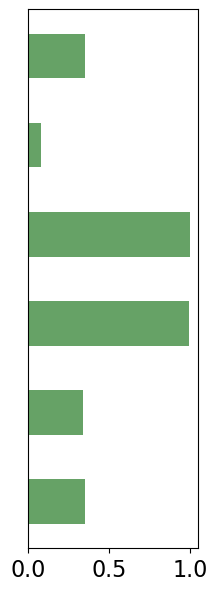

In [98]:
import matplotlib.pyplot as plt
import numpy as np


exps_ss = (real_ss_12param['xi'].T[::2,:][[5,0,1,2,3,4],:], real_ss_12param['xi'].T[1::2,:][[5,0,1,2,3,4],:])

# Fixing random state for reproducibility
np.random.seed(19680801)


plt.rcdefaults()
fig, ax = plt.subplots(figsize=(2.2,7))

# Example data
people = ('')
performance = exps_ss[1].T.mean(axis=0)[::-1]
y_pos = np.arange(len(performance))

ax.barh(y_pos, performance, align='center',color='darkgreen',alpha=0.6,height=0.5)
ax.set_yticks([])
ax.set_yticklabels(people)
ax.invert_yaxis()  # labels read top-to-bottom
plt.xticks([0,0.5,1],fontsize=16)

plt.show()

In [84]:
exps_ss[0]

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 2.08097604e-01,  5.15346456e-01,  6.82575603e-01, ...,
         1.42224944e-01,  3.31777398e-01,  3.30828168e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         4.74575890e-01,  3.73405976e-01,  3.13906350e-01],
       [-3.46343381e-01, -5.73285890e-01, -6.70921200e-01, ...,
        -8.82339396e-01, -9.05772371e-01, -9.14684148e-01],
       [ 1.77262919e-01,  9.64749329e-02, -6.17948423e-04, ...,
         2.46725527e-01,  2.00676564e-01,  2.32034972e-01],
       [-0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00]])

In [87]:
exps_ss[0].T.mean(axis=0)

array([ 0.07072376,  0.3365785 ,  0.08666775, -0.53306611,  0.10134779,
       -0.00285137])

-0.30444606905895655
-0.4267319311525255
0.2845948107380547
-0.9658430828387865
-0.539725779760516
0.2606647055884649
0.3019982447969445
0.17963481389098912
0.00979122758244344
0.09699446408184442
0.32072086161117497
0.5971108228018525
-0.30444606905895655
-0.4267319311525255
0.2845948107380547
-0.9658430828387865
-0.539725779760516
0.2606647055884649
0.3019982447969445
0.17963481389098912
0.00979122758244344
0.09699446408184442
0.32072086161117497
0.5971108228018525


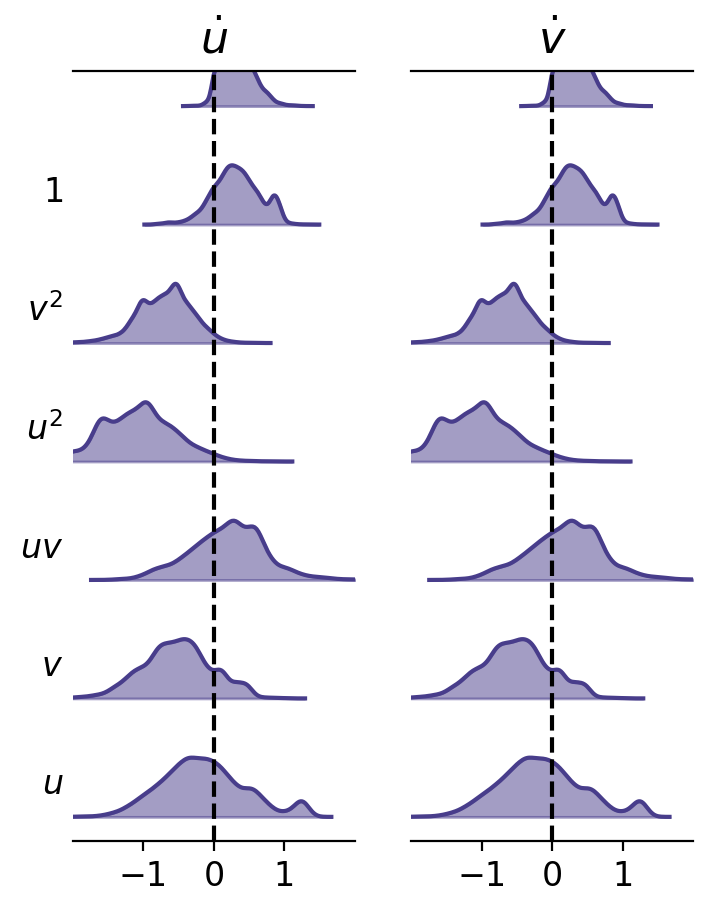

In [99]:
# import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# create some data
n = 1000
exps = (real_gauss['pn'].T, real_gauss['pn'].T)


colors = ['darkslateblue','darkslateblue']

fig, ax = plt.subplots(1,2,dpi=200)
for sbplt, var in enumerate(exps):
    for i, v in enumerate(var):
        sns.kdeplot(data=v,color=colors[sbplt],ax=ax[sbplt])
        #if i==5 and sbplt==1:
        #    sns.kdeplot(data=var[-1,:],color=colors[sbplt],ax=ax[sbplt])

res_gauss = []
for r in range(2):    
# find the line and rescale y-values
    children = ax[r].get_children()
    c = 0
    for child in children:
        if isinstance(child, matplotlib.lines.Line2D):
            x, y = child.get_data()
            print(x[np.argmax(y)])
            res_gauss.append(x[np.argmax(y)])
            y = y/y.max() * 0.5 + c + 0.2
            child.set_data(x,y)
            ax[r].fill_between(x,c + 0.2, y, alpha=0.5,color=colors[r])
            c+= 1
        
for i in range(2):
    ax[i].set_ylim([0,6.5])
    #ax[i].set_xlabel('Coefficient value', fontsize=14)
    ax[i].set_ylabel('')
    ax[i].set_title([r'$\dot{u}$',r'$\dot{v}$'][i % 2], fontsize=16)
    ax[i].plot([0, 0], [0, 20], 'k--')
    ax[i].set_yticks([])  
    ax[i].tick_params(axis='x', which='major', labelsize=12)
    ax[i].spines['left'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].set_xticks([-1,0,1])
    ax[i].set_xlim([-2,2])
    #ax[i].axis('off')
    
ax[0].set_yticks(np.arange(6) + 0.5)
#ax[0].set_yticks(np.array([0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55]) * 0.85 - 0.01)
#ax[0].set_yticklabels([ r'$\dot{u} \ \colon \ u$', r'$\dot{v} \ \colon \ u$',
#                    r'$\dot{u} \ \colon \ v$', r'$\dot{v} \ \colon \ v$',
#                    r'$\dot{u} \ \colon \ u v$', r'$\dot{v} \ \colon \ u v$',
#                    r'$\dot{u} \ \colon \ u^2$', r'$\dot{v} \ \colon \ u^2$',
#                    r'$\dot{u} \ \colon \ v^2$', r'$\dot{v} \ \colon \ v^2$',
#                    r'$\dot{v} \ \colon \ 1$', r'$\dot{u} \ \colon \ 1$'][:6], fontsize=16)

ax[0].set_yticklabels([ r'$u$', 
                    r'$v$', 
                    r'$ u v$', 
                    r'$u^2$', 
                    r'$v^2$', 
                    r'$1$'], fontsize=12)
ax[0].yaxis.set_tick_params(length=0)

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(4, 5)

-0.0026876287530775977
-0.006796408127881071
-0.0002703833511845666
-0.7040288229198701
-0.4182993178208272
0.5227575987474956
0.007702147655146457
0.00445838132354115
-0.00485958011602361
-0.006251513542719467
0.01131087666277275
0.0027636724912109
-0.0026876287530775977
-0.006796408127881071
-0.0002703833511845666
-0.7040288229198701
-0.4182993178208272
0.5227575987474956
0.007702147655146457
0.00445838132354115
-0.00485958011602361
-0.006251513542719467
0.01131087666277275
0.0027636724912109


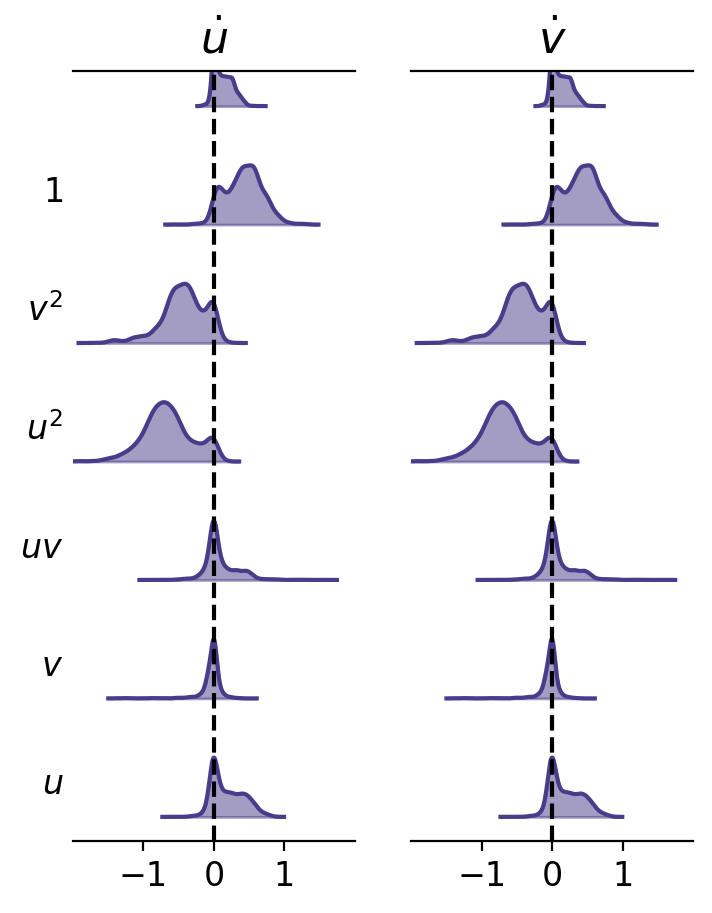

In [102]:
# import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# create some data
n = 1000
exps = (real_rh_12param['pn'].T, real_rh_12param['pn'].T)


colors = ['darkslateblue','darkslateblue']

fig, ax = plt.subplots(1,2,dpi=200)
for sbplt, var in enumerate(exps):
    for i, v in enumerate(var):
        sns.kdeplot(data=v,color=colors[sbplt],ax=ax[sbplt])
        #if i==5 and sbplt==1:
        #    sns.kdeplot(data=var[-1,:],color=colors[sbplt],ax=ax[sbplt])
res_rh = []
        
        
for r in range(2):    
# find the line and rescale y-values
    children = ax[r].get_children()
    c = 0
    for child in children:
        if isinstance(child, matplotlib.lines.Line2D):
            x, y = child.get_data()
            print(x[np.argmax(y)])
            res_rh.append(x[np.argmax(y)])
            y = y/y.max() * 0.5 + c + 0.2
            child.set_data(x,y)
            ax[r].fill_between(x,c + 0.2, y, alpha=0.5,color=colors[r])
            c+= 1
        
for i in range(2):
    ax[i].set_ylim([0,6.5])
    #ax[i].set_xlabel('Coefficient value', fontsize=14)
    ax[i].set_ylabel('')
    ax[i].set_title([r'$\dot{u}$',r'$\dot{v}$'][i % 2], fontsize=16)
    ax[i].plot([0, 0], [0, 20], 'k--')
    ax[i].set_yticks([])  
    ax[i].tick_params(axis='x', which='major', labelsize=12)
    ax[i].spines['left'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].set_xticks([-1,0,1])
    ax[i].set_xlim([-2,2])
    #ax[i].axis('off')
    
ax[0].set_yticks(np.arange(6) + 0.5)
#ax[0].set_yticks(np.array([0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55]) * 0.85 - 0.01)
#ax[0].set_yticklabels([ r'$\dot{u} \ \colon \ u$', r'$\dot{v} \ \colon \ u$',
#                    r'$\dot{u} \ \colon \ v$', r'$\dot{v} \ \colon \ v$',
#                    r'$\dot{u} \ \colon \ u v$', r'$\dot{v} \ \colon \ u v$',
#                    r'$\dot{u} \ \colon \ u^2$', r'$\dot{v} \ \colon \ u^2$',
#                    r'$\dot{u} \ \colon \ v^2$', r'$\dot{v} \ \colon \ v^2$',
#                    r'$\dot{v} \ \colon \ 1$', r'$\dot{u} \ \colon \ 1$'][:6], fontsize=16)

ax[0].set_yticklabels([ r'$u$', 
                    r'$v$', 
                    r'$ u v$', 
                    r'$u^2$', 
                    r'$v^2$', 
                    r'$1$'], fontsize=12)
ax[0].yaxis.set_tick_params(length=0)

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(4, 5)
plt.savefig('fig4b.pdf')

In [103]:
res_rh

[-0.0026876287530775977,
 -0.006796408127881071,
 -0.0002703833511845666,
 -0.7040288229198701,
 -0.4182993178208272,
 0.5227575987474956,
 0.007702147655146457,
 0.00445838132354115,
 -0.00485958011602361,
 -0.006251513542719467,
 0.01131087666277275,
 0.0027636724912109,
 -0.0026876287530775977,
 -0.006796408127881071,
 -0.0002703833511845666,
 -0.7040288229198701,
 -0.4182993178208272,
 0.5227575987474956,
 0.007702147655146457,
 0.00445838132354115,
 -0.00485958011602361,
 -0.006251513542719467,
 0.01131087666277275,
 0.0027636724912109]

In [105]:
np.array(res_rh)[:12] / np.array(res_gauss)[:12]

array([ 8.82793055e-03,  1.59266454e-02, -9.50064235e-04,  7.28926712e-01,
        7.75021934e-01,  2.00547902e+00,  2.55039484e-02,  2.48191385e-02,
       -4.96319800e-01, -6.44522716e-02,  3.52670438e-02,  4.62840797e-03])

In [107]:
np.array(res_rh)[:12] / np.array(res_gauss)[:12]

array([ 8.82793055e-03,  1.59266454e-02, -9.50064235e-04,  7.28926712e-01,
        7.75021934e-01,  2.00547902e+00,  2.55039484e-02,  2.48191385e-02,
       -4.96319800e-01, -6.44522716e-02,  3.52670438e-02,  4.62840797e-03])

In [110]:
import pysindy as ps
from pysindy.differentiation import SmoothedFiniteDifference
sfd = SmoothedFiniteDifference(smoother_kws={'window_length': 5})
dx = sfd(inp)

In [169]:
optimizer = ps.STLSQ(threshold=0.2)
model = ps.SINDy(feature_names=["x", "y"],optimizer=optimizer)
model.fit(inp, t=times)
sim = model.simulate(inp[0], t=times)
model.print()

x' = 0.475 x + -0.355 x y
y' = -0.708 y + 0.417 x y


In [173]:
inp

array([[1.4355505 , 0.24608431],
       [2.25859945, 0.37527858],
       [3.35918816, 0.60290657],
       [3.70372028, 2.16554196],
       [1.7370161 , 3.65435206],
       [0.98574467, 2.56542897],
       [0.86611547, 1.16890049],
       [1.02402602, 0.79977402],
       [1.05273703, 0.51062495],
       [1.21543275, 0.55984181],
       [1.29678062, 0.45525598],
       [1.92842283, 0.49216863],
       [2.72754594, 0.75670926],
       [3.66543894, 1.19966103],
       [2.50264303, 2.81151328],
       [0.93310782, 3.14372711],
       [0.53593885, 1.82717603],
       [0.36367279, 0.97203304],
       [0.69863458, 0.59675446],
       [0.77519727, 0.62136289],
       [1.18193658, 0.52908127]])

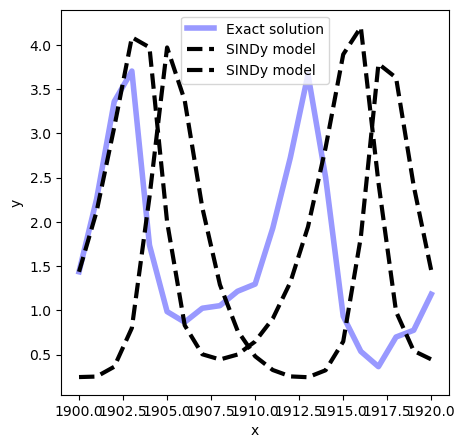

In [174]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
#ax.plot(yobs, y0, "ro", label="Initial condition", alpha=0.6, markersize=8)
ax.plot(times,inp[:, 0], "b", label="Exact solution", alpha=0.4, linewidth=4)
ax.plot(times,sim[:, 0], "k--", label="SINDy model", linewidth=3)
ax.plot(times,sim[:, 1], "k--", label="SINDy model", linewidth=3)
ax.set(xlabel="x", ylabel="y")
ax.legend()
fig.show()

In [122]:
def nonlinear_oscillator_sunode_library_mat(t, y, pn):
    #state = np.array([y.u**3, y.v**3])
    #res = p.pn @ state 
    u,v = y
    state = np.array([u,v,u**2,v**2,u*v,1]) 
    #return state @ np.reshape(pn,(10,2),'C')
    return np.array([pn[0] * u**3 + pn[1] * v**3 + pn[4] * u + pn[6] * v + pn[8] * u**2 + pn[10] * v**2 + pn[12] * u*v + pn[14] * u**2 * v + pn[16] * v**2 * u + pn[18],
     pn[2] * u**3 + pn[3] * v**3 + pn[5] * u + pn[7] * v + pn[9] * u**2 + pn[11] * v**2 + pn[13] * u*v + pn[15] * u**2 * v + pn[17] * v**2 * u + pn[19]])
    #return {'u': du_dt - 1e-5 * y.u**5, 'v' : dv_dt - 1e-5 * y.v**5}
    
    
## Do Bayesian Sindy
def predator_prey_sunode_library_mat(t, y, p):
    u,v = y
    du_dt = pn[0] * u + pn[2] * v + pn[4] * u * v + pn[6] * u**2 + pn[8]* v**2 + pn[10]
    dv_dt = pn[1] * u + pn[3] * v + pn[5] * u * v + pn[7] * u**2 + pn[9]* v**2 + pn[11]
    return np.array([du_dt,dv_dt])



In [134]:
t = np.linspace(0, 40,  80)              # time
res = np.zeros((2,len(times)))
y0 = inp[0]              # initials conditions: 10 rabbits and 5 foxes
pn = np.array([0.475,0,-0.355,0,0,0,0,-1.517,0.432,0,0.209,0.469])
r = ode(predator_prey_sunode_library_mat).set_integrator('dopri5')
r.set_initial_value(y0, times[0])
r.set_f_params(pn)
X[k,:,0] = y0
for i, _t in enumerate(times):
    if i == 0:
        continue
    r.integrate(_t)
    res[:, i] = r.y


/home/hirshs/anaconda3/envs/mars-sunode/lib/python3.7/site-packages/scipy/integrate/_ode.py:1177: UserWarning: dopri5: step size becomes too small
  self.messages.get(istate, unexpected_istate_msg)))


In [135]:
res

array([[ 0.00000000e+00,  1.76641839e+02,  3.50788086e+10,
         3.50788086e+10,  3.50788086e+10,  3.50788086e+10,
         3.50788086e+10,  3.50788086e+10,  3.50788086e+10,
         3.50788086e+10,  3.50788086e+10,  3.50788086e+10,
         3.50788086e+10,  3.50788086e+10,  3.50788086e+10,
         3.50788086e+10,  3.50788086e+10,  3.50788086e+10,
         3.50788086e+10,  3.50788086e+10,  3.50788086e+10],
       [ 0.00000000e+00, -2.67712619e+02, -5.33186052e+10,
        -5.33186052e+10, -5.33186052e+10, -5.33186052e+10,
        -5.33186052e+10, -5.33186052e+10, -5.33186052e+10,
        -5.33186052e+10, -5.33186052e+10, -5.33186052e+10,
        -5.33186052e+10, -5.33186052e+10, -5.33186052e+10,
        -5.33186052e+10, -5.33186052e+10, -5.33186052e+10,
        -5.33186052e+10, -5.33186052e+10, -5.33186052e+10]])

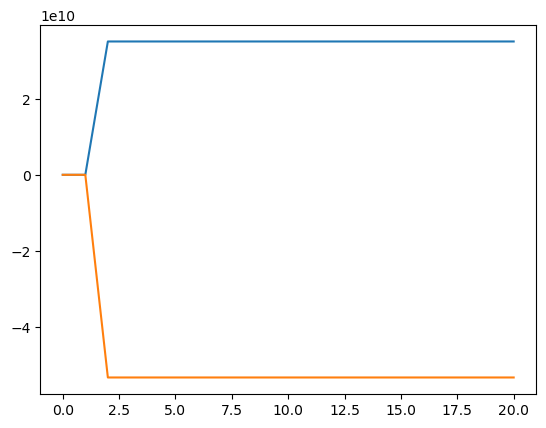

In [140]:
plt.figure()
plt.plot(res.T)
plt.yl
plt.show()